<a href="https://colab.research.google.com/github/lucasnserra/CustomerSegmentation/blob/main/End_to_end_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#Importo Librerias
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

In [3]:
#Cargo el dataset del Raw en git, para este ejercicio se agrego previamente la columna "Tenure" que a diferencia de la Recency mide el tiempo transcurrido desde la primera compra 
datamart_rfmt = pd.read_csv('https://raw.githubusercontent.com/lucasnserra/CustomerSegmentation/main/datamart_rfmt.csv')
datamart_rfmt.head()


,CustomerID,Recency,Frequency,MonetaryValue,Tenure
0,12747,3,25,948.70,362
1,12748,1,888,7046.16,365
2,12749,4,37,813.45,214
3,12820,4,17,268.02,327
4,12822,71,9,146.15,88


In [11]:
#Comienzo proceso de Preprocesamiento de datos
datamart_log = np.log(datamart_rfmt)
#inicio StandardScaler (normalizacion de datos)
scaler = StandardScaler() ; scaler.fit(datamart_log)
datamart_rfmt_normalized = scaler.transform(datamart_log)

In [12]:
#Calculo Nro de Cluster indicados para el analisis a traves del metodo de Elbow (visual)
#comienzo un diccionario vacio para agregar la suma de los errores al cuadrado (SSE)
sse = {}
#Inicio un loop for con k cluster y hago hago el fit sobre KMeans
for k in range(1,11):
  kmeans = KMeans(n_clusters=k,random_state=1).fit(datamart_rfmt_normalized)
#Asigno la suma de la distancias al cuadrado de los k elementos al sse diccionario
  sse[k] = kmeans.inertia_


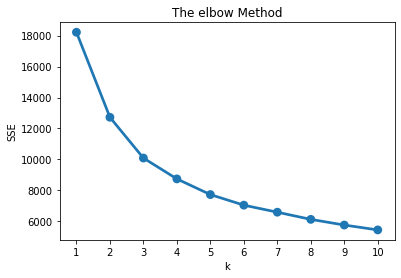

In [13]:
#Creo grafico para elegir el Nro de clusters optimo
plt.title('The elbow Method')
plt.xlabel('k')
plt.ylabel('SSE')
sns.pointplot(x=list(sse.keys()),y=list(sse.values()))
plt.show()

In [15]:
#Luego de observar el grafico se puede determinar que el nro de cluster deberia ser entre 3 y 4
#Iniciamos KMeans con 4 cluster
kmeans = KMeans(n_clusters =4,random_state =1)
kmeans.fit(datamart_rfmt_normalized)
#extraemos labels de los cluster
cluster_labels=kmeans.labels_

In [25]:
#Comienzo a analizar la solución
datamart_rfmt_k4 = datamart_rfmt.assign(Cluster=cluster_labels)
#agrupo por cluster y obtengo la media de RFM y la cantidad
grouped = datamart_rfmt_k4.groupby(['Cluster'])
grouped.agg({'Recency':'mean','Frequency':'mean','MonetaryValue':'mean','Tenure':['mean','count']}).round(1)

Recency Frequency MonetaryValue Tenure      
           mean      mean          mean   mean count
Cluster                                             
0          26.4      42.9         887.6  274.6  1188
1         168.6       6.2         104.9  227.7   920
2         140.1       7.6         151.1  216.5   879
3          30.1       7.5         101.8   40.1   656

In [30]:
#Analisis a traves de un SnakePlot
datamart_rfmt_normalized = pd.DataFrame(data=datamart_rfmt_normalized,index=datamart_rfmt.index,columns=datamart_rfmt.columns)
datamart_rfmt_normalized['Cluster'] = datamart_rfmt_k4.Cluster
datamart_rfmt_normalized.sample(5)

,CustomerID,Recency,Frequency,MonetaryValue,Tenure,Cluster
1439,-0.294590,-0.105674,-0.314127,-0.344413,0.526600,2
2576,0.734619,0.316187,0.386029,0.037838,0.657282,1
3298,1.343742,-0.764461,0.546468,0.562251,-2.502683,3
364,-1.436242,-0.377571,0.443041,-0.388304,-0.146461,2
2074,0.284723,1.084347,-1.221955,-1.392956,0.240888,1


In [33]:
datamart_melt = pd.melt(datamart_rfmt_normalized.reset_index(),
                        id_vars = ['CustomerID','Cluster'],
                        value_vars =['Recency','Frequency','MonetaryValue','Tenure'],
                        var_name = 'Attribute',
                        value_name = 'Value'
                        )
datamart_melt.head()

,CustomerID,Cluster,Attribute,Value
0,-1.914291,0,Recency,-2.002202
1,-1.913516,0,Recency,-2.814518
2,-1.912742,0,Recency,-1.789490
3,-1.857877,0,Recency,-1.789490
4,-1.856336,2,Recency,0.337315


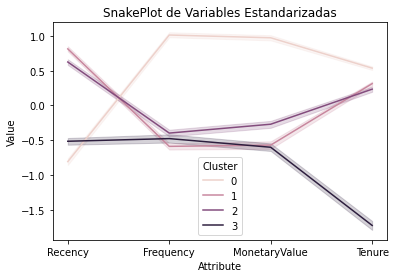

In [38]:
plt.title('SnakePlot de Variables Estandarizadas')
sns.lineplot(data=datamart_melt,x='Attribute',y='Value',hue='Cluster')
plt.show()

In [41]:
#Importancia relativa de atributos
cluster_avg = datamart_rfmt_k4.groupby(['Cluster']).mean()
population_avg = datamart_rfmt.mean()
relative_imp = cluster_avg / population_avg -1
relative_imp.round(1)

,CustomerID,Recency,Frequency,MonetaryValue,Tenure
Cluster,,,,,
0,0.0,-0.7,1.3,1.4,0.3
1,0.1,0.9,-0.7,-0.7,0.1
2,-0.1,0.5,-0.6,-0.6,0.0
3,0.0,-0.7,-0.6,-0.7,-0.8


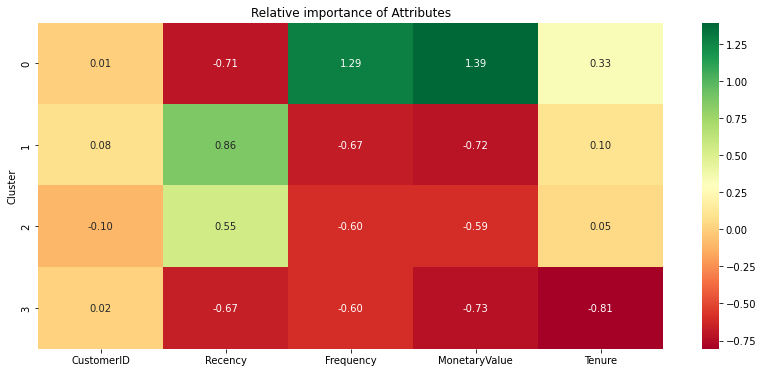

In [47]:
plt.figure(figsize=(14,6))
plt.title('Relative importance of Attributes')
sns.heatmap(data=relative_imp,annot=True,fmt='.2f',cmap='RdYlGn')
